In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
default_rng = default_rng()
import import_ipynb # To install: pip install import_ipynb
import pandas as pd
from dataclasses import dataclass
from typing import Callable
import seaborn as sns
import matplotlib
import os

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Edit me
repetitions = 5000#10000
kappa = 30
bound_to_data = True # Set the upper bound based on n
bits_upper_bound = lambda kappa, epsilon: int(np.ceil(kappa + 1 + np.log2(1/epsilon)))

hepth = 'HEPTH'
hepth_epsilons = [0.02*x for x in range(1, 21)] # 0.02 to 0.2

searchlogs = 'SEARCHLOGS'
searchlogs_epsilons = [0.001*x for x in range(1, 21)]

patent = 'PATENT'
patent_epsilons = [0.01*x for x in range(1, 21)]

adultfrank = 'ADULTFRANK'
adultfrank_epsilons = [0.0002*x for x in range(1, 11)]

medcost = 'MEDCOST'
medcost_epsilons = [0.001*x for x in range(1, 11)]

experiment_name_to_epsilons = {hepth:hepth_epsilons,
                               adultfrank:adultfrank_epsilons,
                               medcost:medcost_epsilons, 
                               searchlogs:searchlogs_epsilons,
                               patent:patent_epsilons}


#Plot details
fig_scale = 1.5
fig_size = (6*fig_scale, 4.5*fig_scale)
marker_size = 30
line_thickness = 5
grid_style = {'grid.color': '0.6', 'grid.linestyle': 'dashed'}
sns.set_style('whitegrid')

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':20})

In [3]:
palette = sns.color_palette("colorblind")
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [4]:
dataset_names = [hepth, adultfrank, medcost, searchlogs, patent]
datasets = {}
describe_frame = pd.DataFrame()

for dataset in dataset_names:
    temp = np.load('../datasets/%s.n4096.npy' % dataset).astype(np.float64)
    temp = temp.reshape(1024,-1).sum(axis=1)
    datasets[dataset] = temp
    describe_frame[dataset] = pd.DataFrame(temp).describe()

In [5]:
describe_frame

,HEPTH,ADULTFRANK,MEDCOST,SEARCHLOGS,PATENT
count,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000
mean,339.271484,17.250977,9.194336,328.016602,27293.189453
std,316.823035,526.133608,93.810120,746.613861,13950.427479
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37.000000,0.000000,0.000000,0.000000,17327.000000
50%,277.500000,0.000000,0.000000,0.000000,31409.000000
75%,556.250000,0.000000,2.000000,477.750000,37693.500000
max,1571.000000,16836.000000,2885.000000,11160.000000,59602.000000


In [6]:
@dataclass
class AlgorithmDetails:
    algorithm: Callable
    name: str
    k: int = 0

@dataclass
class Settings:
    dataset: str
    data: np.ndarray
    epsilons: [float]
    rs: [int]
    upper_bound: int

In [7]:
# Helper functions for saving files
plot_folder = './results/'
if not os.path.exists(plot_folder):
            os.makedirs(plot_folder)
        
plot_name = lambda n: '{folder_name}{file_name}.pdf'.format(folder_name=plot_folder, file_name=n)
csv_name = lambda n: '{folder_name}{file_name}.csv'.format(folder_name=plot_folder, file_name=n)

In [8]:
# MIT License
# Copyright (c) 2020 Ryan McKenna

def exponential_mechanism(x, eps=1.0, sensitivity=1.0, prng=default_rng):
    q = x - x.max()
    p = np.exp(0.5*eps/sensitivity*q)
    p /= p.sum()
    return prng.choice(p.size, p=p)

def permute_and_flip(x, eps=1.0, sensitivity=1.0, prng=default_rng):
    q = x - x.max()
    p = np.exp(0.5*eps/sensitivity*q)
    for i in prng.permutation(p.size):
        if prng.random() <= p[i]:
            return i


In [9]:
# Other distributed methods

def rappor(x, eps=1.0, sensitivity=1.0, n=None, prng=default_rng):
    assert(sensitivity == 1.0) # Only supports 0-1 vectors
    d = x.size
    p = 1/(1+np.exp(eps / d))
    if n is None: # If not known, assume n = largest entry
        n = int(np.max(x))
    ldp_sum = []
    for a in x:
        flips_0_to_1 = prng.binomial(n - a, p)
        flips_1_to_0 = prng.binomial(a, p)
        ldp_sum.append(a + flips_0_to_1 - flips_1_to_0)
    return np.argmax(np.array(ldp_sum))

def secagg(x, eps=1.0, sensitivity=1.0, prng=default_rng):
    d = x.size
    q = x / sensitivity
    geom_parameter = 1 - np.exp(-eps / d)
    q += prng.geometric(geom_parameter, size=q.size)
    q -= prng.geometric(geom_parameter, size=q.size)
    return np.argmax(q)


In [10]:
# Baseline
def random_choice(x, eps=1.0, sensitivity=1.0, prng=default_rng):
    return np.array(default_rng.choice(np.arange(0, len(x))))

In [11]:
# Our method without MPC rounding
def geometric_noisy_max(x, eps=1.0, sensitivity=1.0, prng=default_rng):
    q = x / sensitivity
    geometric_parameter = 1 - np.exp(-0.5 * eps)
    q += prng.geometric(geometric_parameter, size = q.size)
    return np.argmax(q)

# Our method with MPC rounding
def mpc_noisy_max(x, eps=1.0, sensitivity=1.0, prng=default_rng, k=1, parties=3, kappa=30):
    q = np.array(x / sensitivity, dtype=int)
    d = q.size
    trusted_noise_parties = np.floor(parties/2)+1 # +1 for honest majority
    num_shares = parties - 1
    geometric_parameter = 1 - np.exp(-0.5 * eps)
    noise = np.random.negative_binomial(n=1./trusted_noise_parties, p=geometric_parameter, size=(num_shares,d))
    shares = np.random.randint(-2**kappa,2**kappa, size=(num_shares,d))
    share_sum = np.sum(shares, axis=0)
    shares[0] += q - share_sum # Make sum of shares equal to q
    truncated_shares = np.trunc((shares+noise) / k)
    return np.argmax(np.sum(truncated_shares, axis=0))

def error(mechanism, x, k=0, eps=1.0, sensitivity=1.0, prng=default_rng):
    if k>0:
        result = x[mechanism(x, k=k, eps=eps, sensitivity=sensitivity, prng=prng, kappa=kappa)]
    else:
        result = x[mechanism(x, eps=eps, sensitivity=sensitivity, prng=prng)]
    return np.abs(max(x) - result)

In [12]:
calc_total_bits = lambda ds: int(np.ceil(np.log2(max(ds))))

experiment_settings = {}

for name in experiment_name_to_epsilons:
    epsilons = experiment_name_to_epsilons[name]
    bits = calc_total_bits(datasets[name]) if bound_to_data else bits_upper_bound(kappa, min(epsilons))
    experiment_settings[name] = Settings(dataset=name, 
                                    data=datasets[name], 
                                    epsilons=epsilons,
                                    rs=range(0, bits+1),
                                    upper_bound=bits
                                   )


In [13]:
# r is the remaining bits, k is the bits to truncate
def r_to_k_conversion(upper, r):
    return 2**(upper-r)

# RUN EXPERIMENTS

In [14]:
all_errors = {}
big_frame = {}


for setting in experiment_settings.values():
    x = setting.data
    error_frame = pd.DataFrame()
    small_frame = pd.DataFrame()
    all_to_add = []
    big_to_add = []
    
    algorithms = [
    AlgorithmDetails(algorithm=exponential_mechanism, name='Exponential mechanism'),
    AlgorithmDetails(algorithm=permute_and_flip, name='Permute-and-flip'),
    AlgorithmDetails(algorithm=geometric_noisy_max, name='Geometric noisy max'),
    AlgorithmDetails(algorithm=rappor, name='Randomized response'),
    AlgorithmDetails(algorithm=secagg, name='Secure aggregation'),
    AlgorithmDetails(algorithm=random_choice, name='Random choice'),
    ]

    our_name = 'Noise-and-round'
    our_algorithms = [AlgorithmDetails(algorithm=mpc_noisy_max, name='{name}, r={r}'.format(name=our_name, r=r), k=r_to_k_conversion(upper=setting.upper_bound, r=r)) 
                 for r in setting.rs]
    algorithms+=our_algorithms
    
    for algorithm in algorithms:
        for eps in setting.epsilons:
            results = [error(algorithm.algorithm, x, eps=eps, k=algorithm.k) for _ in range(repetitions)]
            label = '{algorithm} eps={epsilon}'.format(algorithm=algorithm.name, epsilon=eps)
            temp_frame = pd.DataFrame({'Error':results,
                                               'Epsilon': np.repeat(eps, len(results)),
                                               'Algorithm': np.repeat(algorithm.name, len(results)),
                                              })
            big_to_add.append(pd.DataFrame(data=results, columns=[label]))
            all_to_add.append(temp_frame)

    big_frame[setting.dataset] = pd.concat(big_to_add)
    all_errors[setting.dataset] = pd.concat(all_to_add)
    
    #Save to file
    all_errors[setting.dataset].to_csv(csv_name(setting.dataset))
    big_frame[setting.dataset].describe().to_csv(csv_name('describe_{file_name}'.format(file_name=setting.dataset)))


In [15]:
pd.set_option('display.max_columns', 200)

# RESULTS BELOW

## HEPTH RESULTS

Max truncation  11
Upper bound is 11
HEPTH


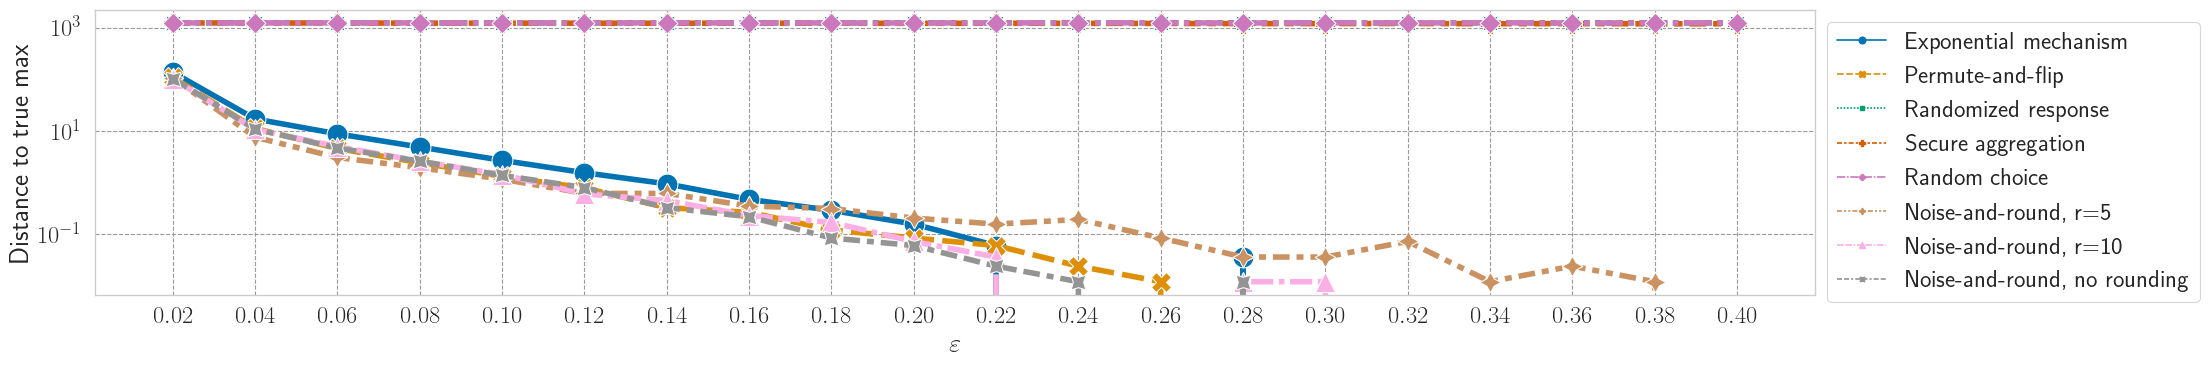

In [159]:
name = hepth
print('Max truncation ', calc_total_bits(datasets[name]))
bits = max(experiment_settings[name].rs)
display_rs = [bits, 10, 5,]#4, 3, 2, 1]
print('Upper bound is', bits)



# Filter away r values we don't want to show in plot
hide_rs = list(set(experiment_settings[name].rs)-set(display_rs))
plot_df_hepth = all_errors[hepth]
for r in hide_rs:
    plot_df_hepth = plot_df_hepth[(plot_df_hepth.Algorithm != '{name}, r={r}'.format(name=our_name, r=r))]

plot_df_hepth = plot_df_hepth[plot_df_hepth.Algorithm != 'Geometric noisy max']
    
old_name = '{name}, r={r}'.format(name=our_name, r=bits)
new_name = '{name}, no rounding'.format(name=our_name)
plot_df_hepth = plot_df_hepth.replace(old_name, new_name)



xticks = experiment_settings[name].epsilons
xlabel = r'$\varepsilon$'
xscale = 'linear'
yscale = 'log'


plt.rcParams['figure.figsize'] = fig_size

    
#Print dataset name and plot
print(name)
sns.set_theme(style=grid_style, palette=palette, context='paper', font='sans-serif', font_scale=2, color_codes=True)
g = sns.lineplot(data=plot_df_hepth,
                 hue='Algorithm',
                 markers=True,
                 style='Algorithm',
                 x='Epsilon',
                 y='Error',
                 errorbar='sd', #Plots error bars at +-1 std
                 #err_style='bars',
                 estimator='mean',
                 ms=marker_size,
                 linewidth=line_thickness,
                 err_style=None,
                )

g.set_xscale(xscale)
g.set_yscale(yscale)
g.set_ylabel(r'Distance to true max')
g.set_xlabel(xlabel)
g.set_xticks(xticks)
g.legend().set_title(None)
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
g.figure.savefig(plot_name(name),bbox_inches='tight', pad_inches=0.5)

In [129]:
big_frame[name].describe()

,Exponential mechanism eps=0.02,Exponential mechanism eps=0.04,Exponential mechanism eps=0.06,Exponential mechanism eps=0.08,Exponential mechanism eps=0.1,Exponential mechanism eps=0.12,Exponential mechanism eps=0.14,Exponential mechanism eps=0.16,Exponential mechanism eps=0.18,Exponential mechanism eps=0.2,Exponential mechanism eps=0.22,Exponential mechanism eps=0.24,Exponential mechanism eps=0.26,Exponential mechanism eps=0.28,Exponential mechanism eps=0.3,Exponential mechanism eps=0.32,Exponential mechanism eps=0.34,Exponential mechanism eps=0.36,Exponential mechanism eps=0.38,Exponential mechanism eps=0.4,Permute-and-flip eps=0.02,Permute-and-flip eps=0.04,Permute-and-flip eps=0.06,Permute-and-flip eps=0.08,Permute-and-flip eps=0.1,Permute-and-flip eps=0.12,Permute-and-flip eps=0.14,Permute-and-flip eps=0.16,Permute-and-flip eps=0.18,Permute-and-flip eps=0.2,Permute-and-flip eps=0.22,Permute-and-flip eps=0.24,Permute-and-flip eps=0.26,Permute-and-flip eps=0.28,Permute-and-flip eps=0.3,Permute-and-flip eps=0.32,Permute-and-flip eps=0.34,Permute-and-flip eps=0.36,Permute-and-flip eps=0.38,Permute-and-flip eps=0.4,Geometric noisy max eps=0.02,Geometric noisy max eps=0.04,Geometric noisy max eps=0.06,Geometric noisy max eps=0.08,Geometric noisy max eps=0.1,Geometric noisy max eps=0.12,Geometric noisy max eps=0.14,Geometric noisy max eps=0.16,Geometric noisy max eps=0.18,Geometric noisy max eps=0.2,Geometric noisy max eps=0.22,Geometric noisy max eps=0.24,Geometric noisy max eps=0.26,Geometric noisy max eps=0.28,Geometric noisy max eps=0.3,Geometric noisy max eps=0.32,Geometric noisy max eps=0.34,Geometric noisy max eps=0.36,Geometric noisy max eps=0.38,Geometric noisy max eps=0.4,Randomized response eps=0.02,Randomized response eps=0.04,Randomized response eps=0.06,Randomized response eps=0.08,Randomized response eps=0.1,Randomized response eps=0.12,Randomized response eps=0.14,Randomized response eps=0.16,Randomized response eps=0.18,Randomized response eps=0.2,Randomized response eps=0.22,Randomized response eps=0.24,Randomized response eps=0.26,Randomized response eps=0.28,Randomized response eps=0.3,Randomized response eps=0.32,Randomized response eps=0.34,Randomized response eps=0.36,Randomized response eps=0.38,Randomized response eps=0.4,Secure aggregation eps=0.02,Secure aggregation eps=0.04,Secure aggregation eps=0.06,Secure aggregation eps=0.08,Secure aggregation eps=0.1,Secure aggregation eps=0.12,Secure aggregation eps=0.14,Secure aggregation eps=0.16,Secure aggregation eps=0.18,Secure aggregation eps=0.2,Secure aggregation eps=0.22,Secure aggregation eps=0.24,Secure aggregation eps=0.26,Secure aggregation eps=0.28,Secure aggregation eps=0.3,Secure aggregation eps=0.32,Secure aggregation eps=0.34,Secure aggregation eps=0.36,Secure aggregation eps=0.38,Secure aggregation eps=0.4,...,"Noise-and-round, r=7 eps=0.02","Noise-and-round, r=7 eps=0.04","Noise-and-round, r=7 eps=0.06","Noise-and-round, r=7 eps=0.08","Noise-and-round, r=7 eps=0.1","Noise-and-round, r=7 eps=0.12","Noise-and-round, r=7 eps=0.14","Noise-and-round, r=7 eps=0.16","Noise-and-round, r=7 eps=0.18","Noise-and-round, r=7 eps=0.2","Noise-and-round, r=7 eps=0.22","Noise-and-round, r=7 eps=0.24","Noise-and-round, r=7 eps=0.26","Noise-and-round, r=7 eps=0.28","Noise-and-round, r=7 eps=0.3","Noise-and-round, r=7 eps=0.32","Noise-and-round, r=7 eps=0.34","Noise-and-round, r=7 eps=0.36","Noise-and-round, r=7 eps=0.38","Noise-and-round, r=7 eps=0.4","Noise-and-round, r=8 eps=0.02","Noise-and-round, r=8 eps=0.04","Noise-and-round, r=8 eps=0.06","Noise-and-round, r=8 eps=0.08","Noise-and-round, r=8 eps=0.1","Noise-and-round, r=8 eps=0.12","Noise-and-round, r=8 eps=0.14","Noise-and-round, r=8 eps=0.16","Noise-and-round, r=8 eps=0.18","Noise-and-round, r=8 eps=0.2","Noise-and-round, r=8 eps=0.22","Noise-and-round, r=8 eps=0.24","Noise-and-round, r=8 eps=0.26","Noise-and-round, r=8 eps=0.28","Noise-and-round, r=8 eps=0.3","Noise-and-round, r=8 eps=0.32","Noise-and

## PATENT RESULTS

Max truncation  16
Upper bound is 16
PATENT


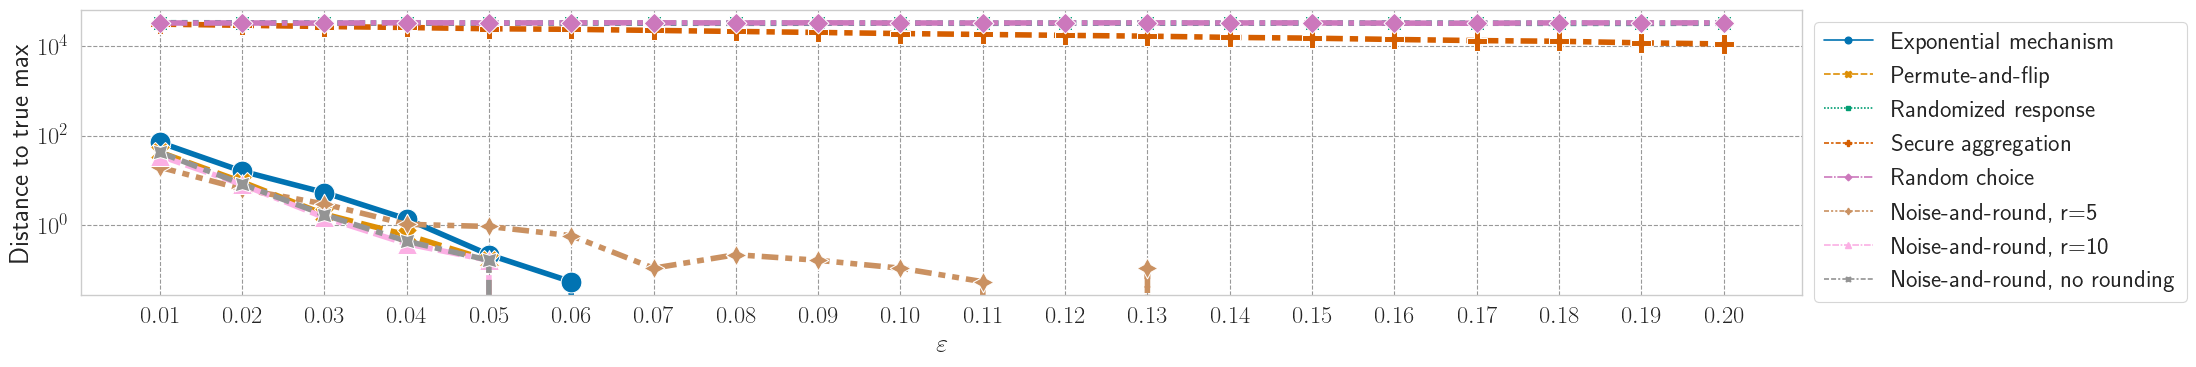

In [130]:
name = patent
print('Max truncation ', calc_total_bits(datasets[name]))
bits = max(experiment_settings[name].rs)
display_rs = [bits, 10, 5,]# 4, 3, 2, 1]
print('Upper bound is', bits)

# Filter away r values we don't want to show in plot
hide_rs = list(set(experiment_settings[name].rs)-set(display_rs))
plot_df_patent = all_errors[name]
for r in hide_rs:
    plot_df_patent = plot_df_patent[(plot_df_patent.Algorithm != '{name}, r={r}'.format(name=our_name, r=r))]

plot_df_patent = plot_df_patent[plot_df_patent.Algorithm != 'Geometric noisy max']
    

old_name = '{name}, r={r}'.format(name=our_name, r=bits)
new_name = '{name}, no rounding'.format(name=our_name)
plot_df_patent = plot_df_patent.replace(old_name, new_name)


xticks = experiment_settings[name].epsilons
xlabel = r'$\varepsilon$'
xscale = 'linear'
yscale = 'log'

    
#Print dataset name and plot
print(name)
sns.set_theme(style=grid_style, palette=palette, context='paper', font='sans-serif', font_scale=2, color_codes=True)
g = sns.lineplot(data=plot_df_patent,
                 hue='Algorithm',
                 markers=True,
                 style='Algorithm',
                 x='Epsilon',
                 y='Error',
                 errorbar='sd', #Plots error bars at +-1 std
                 #err_style='bars',
                 estimator='mean',
                 ms=marker_size,
                 linewidth=line_thickness,
                 err_style=None,
                )

g.set_xscale(xscale)
g.set_yscale(yscale)
g.set_ylabel(r'Distance to true max')
g.set_xlabel(xlabel)
g.set_xticks(xticks)
g.legend().set_title(None)

sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
g.figure.savefig(plot_name(name),bbox_inches='tight', pad_inches=0.5)

In [131]:
big_frame[name].describe()

,Exponential mechanism eps=0.01,Exponential mechanism eps=0.02,Exponential mechanism eps=0.03,Exponential mechanism eps=0.04,Exponential mechanism eps=0.05,Exponential mechanism eps=0.06,Exponential mechanism eps=0.07,Exponential mechanism eps=0.08,Exponential mechanism eps=0.09,Exponential mechanism eps=0.1,Exponential mechanism eps=0.11,Exponential mechanism eps=0.12,Exponential mechanism eps=0.13,Exponential mechanism eps=0.14,Exponential mechanism eps=0.15,Exponential mechanism eps=0.16,Exponential mechanism eps=0.17,Exponential mechanism eps=0.18,Exponential mechanism eps=0.19,Exponential mechanism eps=0.2,Permute-and-flip eps=0.01,Permute-and-flip eps=0.02,Permute-and-flip eps=0.03,Permute-and-flip eps=0.04,Permute-and-flip eps=0.05,Permute-and-flip eps=0.06,Permute-and-flip eps=0.07,Permute-and-flip eps=0.08,Permute-and-flip eps=0.09,Permute-and-flip eps=0.1,Permute-and-flip eps=0.11,Permute-and-flip eps=0.12,Permute-and-flip eps=0.13,Permute-and-flip eps=0.14,Permute-and-flip eps=0.15,Permute-and-flip eps=0.16,Permute-and-flip eps=0.17,Permute-and-flip eps=0.18,Permute-and-flip eps=0.19,Permute-and-flip eps=0.2,Geometric noisy max eps=0.01,Geometric noisy max eps=0.02,Geometric noisy max eps=0.03,Geometric noisy max eps=0.04,Geometric noisy max eps=0.05,Geometric noisy max eps=0.06,Geometric noisy max eps=0.07,Geometric noisy max eps=0.08,Geometric noisy max eps=0.09,Geometric noisy max eps=0.1,Geometric noisy max eps=0.11,Geometric noisy max eps=0.12,Geometric noisy max eps=0.13,Geometric noisy max eps=0.14,Geometric noisy max eps=0.15,Geometric noisy max eps=0.16,Geometric noisy max eps=0.17,Geometric noisy max eps=0.18,Geometric noisy max eps=0.19,Geometric noisy max eps=0.2,Randomized response eps=0.01,Randomized response eps=0.02,Randomized response eps=0.03,Randomized response eps=0.04,Randomized response eps=0.05,Randomized response eps=0.06,Randomized response eps=0.07,Randomized response eps=0.08,Randomized response eps=0.09,Randomized response eps=0.1,Randomized response eps=0.11,Randomized response eps=0.12,Randomized response eps=0.13,Randomized response eps=0.14,Randomized response eps=0.15,Randomized response eps=0.16,Randomized response eps=0.17,Randomized response eps=0.18,Randomized response eps=0.19,Randomized response eps=0.2,Secure aggregation eps=0.01,Secure aggregation eps=0.02,Secure aggregation eps=0.03,Secure aggregation eps=0.04,Secure aggregation eps=0.05,Secure aggregation eps=0.06,Secure aggregation eps=0.07,Secure aggregation eps=0.08,Secure aggregation eps=0.09,Secure aggregation eps=0.1,Secure aggregation eps=0.11,Secure aggregation eps=0.12,Secure aggregation eps=0.13,Secure aggregation eps=0.14,Secure aggregation eps=0.15,Secure aggregation eps=0.16,Secure aggregation eps=0.17,Secure aggregation eps=0.18,Secure aggregation eps=0.19,Secure aggregation eps=0.2,...,"Noise-and-round, r=12 eps=0.01","Noise-and-round, r=12 eps=0.02","Noise-and-round, r=12 eps=0.03","Noise-and-round, r=12 eps=0.04","Noise-and-round, r=12 eps=0.05","Noise-and-round, r=12 eps=0.06","Noise-and-round, r=12 eps=0.07","Noise-and-round, r=12 eps=0.08","Noise-and-round, r=12 eps=0.09","Noise-and-round, r=12 eps=0.1","Noise-and-round, r=12 eps=0.11","Noise-and-round, r=12 eps=0.12","Noise-and-round, r=12 eps=0.13","Noise-and-round, r=12 eps=0.14","Noise-and-round, r=12 eps=0.15","Noise-and-round, r=12 eps=0.16","Noise-and-round, r=12 eps=0.17","Noise-and-round, r=12 eps=0.18","Noise-and-round, r=12 eps=0.19","Noise-and-round, r=12 eps=0.2","Noise-and-round, r=13 eps=0.01","Noise-and-round, r=13 eps=0.02","Noise-and-round, r=13 eps=0.03","Noise-and-round, r=13 eps=0.04","Noise-and-round, r=13 eps=0.05","Noise-and-round, r=13 eps=0.06","Noise-and-round, r=13 eps=0.07","Noise-and-round, r=13 eps=0.08","Noise-and-round, r=13 eps=0.09","Noise-and-round, r=13 eps=0.1","Noise-and-round, r=13 eps=0.11","Noise-and-round, r=13 eps=0.12","Noise-and-round, r=13 eps=0.13","Noise-and-round, r=13 eps=0.14","Noise-and-round, r=13 eps

In [132]:
all_errors['SEARCHLOGS'].Epsilon.unique()

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 ])

## SEARCHLOGS RESULTS

Max truncation  14
Upper bound is 14
SEARCHLOGS


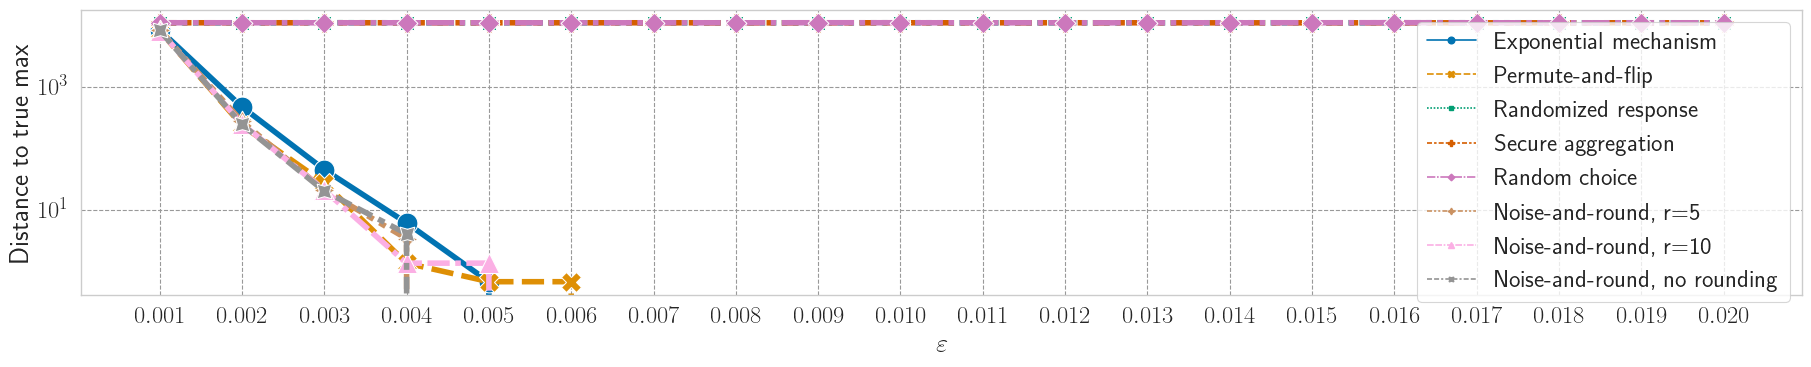

In [142]:
name = searchlogs
print('Max truncation ', calc_total_bits(datasets[name]))
bits = max(experiment_settings[name].rs)
display_rs = [bits, 10, 5,] # 4, 3, 2, 1]
print('Upper bound is', bits)

# Filter away r values we don't want to show in plot
hide_rs = list(set(experiment_settings[name].rs)-set(display_rs))
plot_df_searchlogs = all_errors[name]
for r in hide_rs:
    plot_df_searchlogs = plot_df_searchlogs[(plot_df_searchlogs.Algorithm != '{name}, r={r}'.format(name=our_name, r=r))]

plot_df_searchlogs = plot_df_searchlogs[plot_df_searchlogs.Algorithm != 'Geometric noisy max']
    

old_name = '{name}, r={r}'.format(name=our_name, r=bits)
new_name = '{name}, no rounding'.format(name=our_name)
plot_df_searchlogs = plot_df_searchlogs.replace(old_name, new_name)


xticks = experiment_settings[name].epsilons
xlabel = r'$\varepsilon$'
xscale = 'linear'
yscale = 'log'

    
#Print dataset name and plot
print(name)
sns.set_theme(style=grid_style, palette=palette, context='paper', font='sans-serif', font_scale=2, color_codes=True)
g = sns.lineplot(data=plot_df_searchlogs,
                 hue='Algorithm',
                 markers=True,
                 style='Algorithm',
                 x='Epsilon',
                 y='Error',
                 errorbar='sd', #Plots error bars at +-1 std
                 #err_style='bars',
                 estimator='mean',
                 ms=marker_size,
                 linewidth=line_thickness,
                 err_style=None,
                )

g.set_xscale(xscale)
g.set_yscale(yscale)
g.set_ylabel(r'Distance to true max')
g.set_xlabel(xlabel)
g.set_xticks(xticks)
g.legend().set_title(None)
g.figure.savefig(plot_name(name),bbox_inches='tight', pad_inches=0.5)

In [134]:
big_frame[name].describe()

,Exponential mechanism eps=0.001,Exponential mechanism eps=0.002,Exponential mechanism eps=0.003,Exponential mechanism eps=0.004,Exponential mechanism eps=0.005,Exponential mechanism eps=0.006,Exponential mechanism eps=0.007,Exponential mechanism eps=0.008,Exponential mechanism eps=0.009000000000000001,Exponential mechanism eps=0.01,Exponential mechanism eps=0.011,Exponential mechanism eps=0.012,Exponential mechanism eps=0.013000000000000001,Exponential mechanism eps=0.014,Exponential mechanism eps=0.015,Exponential mechanism eps=0.016,Exponential mechanism eps=0.017,Exponential mechanism eps=0.018000000000000002,Exponential mechanism eps=0.019,Exponential mechanism eps=0.02,Permute-and-flip eps=0.001,Permute-and-flip eps=0.002,Permute-and-flip eps=0.003,Permute-and-flip eps=0.004,Permute-and-flip eps=0.005,Permute-and-flip eps=0.006,Permute-and-flip eps=0.007,Permute-and-flip eps=0.008,Permute-and-flip eps=0.009000000000000001,Permute-and-flip eps=0.01,Permute-and-flip eps=0.011,Permute-and-flip eps=0.012,Permute-and-flip eps=0.013000000000000001,Permute-and-flip eps=0.014,Permute-and-flip eps=0.015,Permute-and-flip eps=0.016,Permute-and-flip eps=0.017,Permute-and-flip eps=0.018000000000000002,Permute-and-flip eps=0.019,Permute-and-flip eps=0.02,Geometric noisy max eps=0.001,Geometric noisy max eps=0.002,Geometric noisy max eps=0.003,Geometric noisy max eps=0.004,Geometric noisy max eps=0.005,Geometric noisy max eps=0.006,Geometric noisy max eps=0.007,Geometric noisy max eps=0.008,Geometric noisy max eps=0.009000000000000001,Geometric noisy max eps=0.01,Geometric noisy max eps=0.011,Geometric noisy max eps=0.012,Geometric noisy max eps=0.013000000000000001,Geometric noisy max eps=0.014,Geometric noisy max eps=0.015,Geometric noisy max eps=0.016,Geometric noisy max eps=0.017,Geometric noisy max eps=0.018000000000000002,Geometric noisy max eps=0.019,Geometric noisy max eps=0.02,Randomized response eps=0.001,Randomized response eps=0.002,Randomized response eps=0.003,Randomized response eps=0.004,Randomized response eps=0.005,Randomized response eps=0.006,Randomized response eps=0.007,Randomized response eps=0.008,Randomized response eps=0.009000000000000001,Randomized response eps=0.01,Randomized response eps=0.011,Randomized response eps=0.012,Randomized response eps=0.013000000000000001,Randomized response eps=0.014,Randomized response eps=0.015,Randomized response eps=0.016,Randomized response eps=0.017,Randomized response eps=0.018000000000000002,Randomized response eps=0.019,Randomized response eps=0.02,Secure aggregation eps=0.001,Secure aggregation eps=0.002,Secure aggregation eps=0.003,Secure aggregation eps=0.004,Secure aggregation eps=0.005,Secure aggregation eps=0.006,Secure aggregation eps=0.007,Secure aggregation eps=0.008,Secure aggregation eps=0.009000000000000001,Secure aggregation eps=0.01,Secure aggregation eps=0.011,Secure aggregation eps=0.012,Secure aggregation eps=0.013000000000000001,Secure aggregation eps=0.014,Secure aggregation eps=0.015,Secure aggregation eps=0.016,Secure aggregation eps=0.017,Secure aggregation eps=0.018000000000000002,Secure aggregation eps=0.019,Secure aggregation eps=0.02,...,"Noise-and-round, r=10 eps=0.001","Noise-and-round, r=10 eps=0.002","Noise-and-round, r=10 eps=0.003","Noise-and-round, r=10 eps=0.004","Noise-and-round, r=10 eps=0.005","Noise-and-round, r=10 eps=0.006","Noise-and-round, r=10 eps=0.007","Noise-and-round, r=10 eps=0.008","Noise-and-round, r=10 eps=0.009000000000000001","Noise-and-round, r=10 eps=0.01","Noise-and-round, r=10 eps=0.011","Noise-and-round, r=10 eps=0.012","Noise-and-round, r=10 eps=0.013000000000000001","Noise-and-round, r=10 eps=0.014","Noise-and-round, r=10 eps=0.015","Noise-and-round, r=10 eps=0.016","Noise-and-round, r=10 eps=0.017","Noise-and-round, r=10 eps=0.018000000000000002","Noise-and-round, r=10 eps=0.019","Noise-and-round, r=10 eps=0.02","Noise-and-round, r=11 eps=0.001","Noise-and-round, r=11 eps=0.002","Noise-and-round, r=11 eps=0.

## MEDCOST

Max truncation  12
Upper bound is 12
MEDCOST


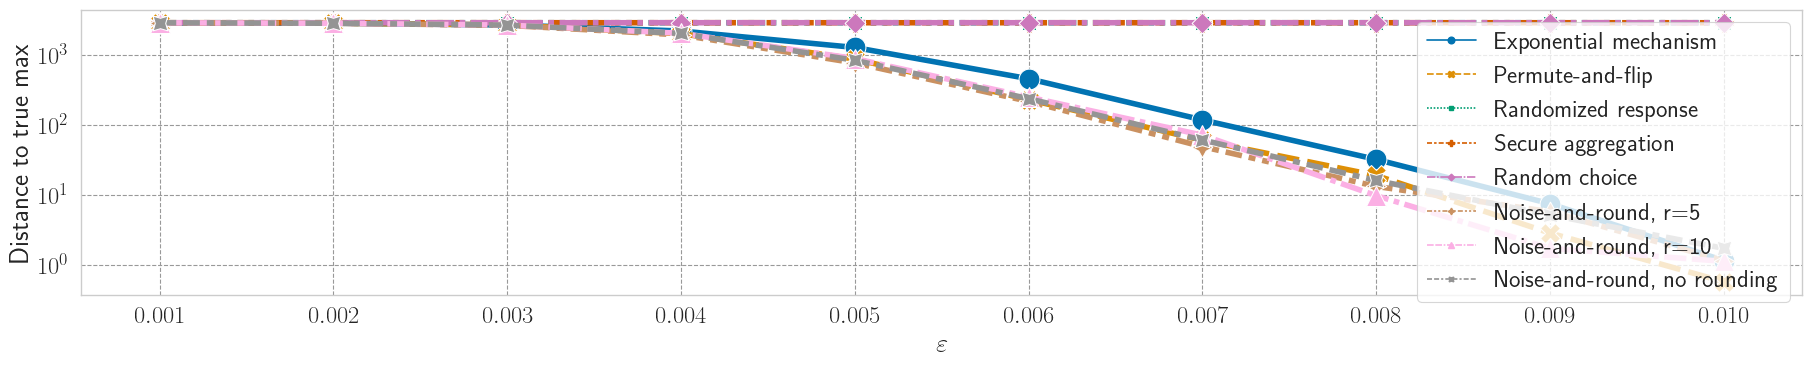

In [135]:
name = medcost
print('Max truncation ', calc_total_bits(datasets[name]))
bits = max(experiment_settings[name].rs)
display_rs = [bits, 10, 5]
print('Upper bound is', bits)

# Filter away r values we don't want to show in plot
hide_rs = list(set(experiment_settings[name].rs)-set(display_rs))
plot_df_searchlogs = all_errors[name]
for r in hide_rs:
    plot_df_searchlogs = plot_df_searchlogs[(plot_df_searchlogs.Algorithm != '{name}, r={r}'.format(name=our_name, r=r))]

plot_df_searchlogs = plot_df_searchlogs[plot_df_searchlogs.Algorithm != 'Geometric noisy max']
    

old_name = '{name}, r={r}'.format(name=our_name, r=bits)
new_name = '{name}, no rounding'.format(name=our_name)
plot_df_searchlogs = plot_df_searchlogs.replace(old_name, new_name)


xticks = experiment_settings[name].epsilons
xlabel = r'$\varepsilon$'
xscale = 'linear'
yscale = 'log'

    
#Print dataset name and plot
print(name)
sns.set_theme(style=grid_style, palette=palette, context='paper', font='sans-serif', font_scale=2, color_codes=True)
g = sns.lineplot(data=plot_df_searchlogs,
                 hue='Algorithm',
                 markers=True,
                 style='Algorithm',
                 x='Epsilon',
                 y='Error',
                 errorbar='sd', #Plots error bars at +-1 std
                 #err_style='bars',
                 estimator='mean',
                 ms=marker_size,
                 linewidth=line_thickness,
                 err_style=None,
                )

g.set_xscale(xscale)
g.set_yscale(yscale)
g.set_ylabel(r'Distance to true max')
g.set_xlabel(xlabel)
g.set_xticks(xticks)
g.legend().set_title(None)
g.figure.savefig(plot_name(name),bbox_inches='tight', pad_inches=0.5)

In [136]:
big_frame[name].describe()

,Exponential mechanism eps=0.001,Exponential mechanism eps=0.002,Exponential mechanism eps=0.003,Exponential mechanism eps=0.004,Exponential mechanism eps=0.005,Exponential mechanism eps=0.006,Exponential mechanism eps=0.007,Exponential mechanism eps=0.008,Exponential mechanism eps=0.009000000000000001,Exponential mechanism eps=0.01,Permute-and-flip eps=0.001,Permute-and-flip eps=0.002,Permute-and-flip eps=0.003,Permute-and-flip eps=0.004,Permute-and-flip eps=0.005,Permute-and-flip eps=0.006,Permute-and-flip eps=0.007,Permute-and-flip eps=0.008,Permute-and-flip eps=0.009000000000000001,Permute-and-flip eps=0.01,Geometric noisy max eps=0.001,Geometric noisy max eps=0.002,Geometric noisy max eps=0.003,Geometric noisy max eps=0.004,Geometric noisy max eps=0.005,Geometric noisy max eps=0.006,Geometric noisy max eps=0.007,Geometric noisy max eps=0.008,Geometric noisy max eps=0.009000000000000001,Geometric noisy max eps=0.01,Randomized response eps=0.001,Randomized response eps=0.002,Randomized response eps=0.003,Randomized response eps=0.004,Randomized response eps=0.005,Randomized response eps=0.006,Randomized response eps=0.007,Randomized response eps=0.008,Randomized response eps=0.009000000000000001,Randomized response eps=0.01,Secure aggregation eps=0.001,Secure aggregation eps=0.002,Secure aggregation eps=0.003,Secure aggregation eps=0.004,Secure aggregation eps=0.005,Secure aggregation eps=0.006,Secure aggregation eps=0.007,Secure aggregation eps=0.008,Secure aggregation eps=0.009000000000000001,Secure aggregation eps=0.01,Random choice eps=0.001,Random choice eps=0.002,Random choice eps=0.003,Random choice eps=0.004,Random choice eps=0.005,Random choice eps=0.006,Random choice eps=0.007,Random choice eps=0.008,Random choice eps=0.009000000000000001,Random choice eps=0.01,"Noise-and-round, r=0 eps=0.001","Noise-and-round, r=0 eps=0.002","Noise-and-round, r=0 eps=0.003","Noise-and-round, r=0 eps=0.004","Noise-and-round, r=0 eps=0.005","Noise-and-round, r=0 eps=0.006","Noise-and-round, r=0 eps=0.007","Noise-and-round, r=0 eps=0.008","Noise-and-round, r=0 eps=0.009000000000000001","Noise-and-round, r=0 eps=0.01","Noise-and-round, r=1 eps=0.001","Noise-and-round, r=1 eps=0.002","Noise-and-round, r=1 eps=0.003","Noise-and-round, r=1 eps=0.004","Noise-and-round, r=1 eps=0.005","Noise-and-round, r=1 eps=0.006","Noise-and-round, r=1 eps=0.007","Noise-and-round, r=1 eps=0.008","Noise-and-round, r=1 eps=0.009000000000000001","Noise-and-round, r=1 eps=0.01","Noise-and-round, r=2 eps=0.001","Noise-and-round, r=2 eps=0.002","Noise-and-round, r=2 eps=0.003","Noise-and-round, r=2 eps=0.004","Noise-and-round, r=2 eps=0.005","Noise-and-round, r=2 eps=0.006","Noise-and-round, r=2 eps=0.007","Noise-and-round, r=2 eps=0.008","Noise-and-round, r=2 eps=0.009000000000000001","Noise-and-round, r=2 eps=0.01","Noise-and-round, r=3 eps=0.001","Noise-and-round, r=3 eps=0.002","Noise-and-round, r=3 eps=0.003","Noise-and-round, r=3 eps=0.004","Noise-and-round, r=3 eps=0.005","Noise-and-round, r=3 eps=0.006","Noise-and-round, r=3 eps=0.007","Noise-and-round, r=3 eps=0.008","Noise-and-round, r=3 eps=0.009000000000000001","Noise-and-round, r=3 eps=0.01","Noise-and-round, r=4 eps=0.001","Noise-and-round, r=4 eps=0.002","Noise-and-round, r=4 eps=0.003","Noise-and-round, r=4 eps=0.004","Noise-and-round, r=4 eps=0.005","Noise-and-round, r=4 eps=0.006","Noise-and-round, r=4 eps=0.007","Noise-and-round, r=4 eps=0.008","Noise-and-round, r=4 eps=0.009000000000000001","Noise-and-round, r=4 eps=0.01","Noise-and-round, r=5 eps=0.001","Noise-and-round, r=5 eps=0.002","Noise-and-round, r=5 eps=0.003","Noise-and-round, r=5 eps=0.004","Noise-and-round, r=5 eps=0.005","Noise-and-round, r=5 eps=0.006","Noise-and-round, r=5 eps=0.007","Noise-and-round, r=5 eps=0.008","Noise-and-round, r=5 eps=0.009000000000000001","Noise-and-round, r=5 eps=0.01","Noise-and-round, r=6 eps=0.001","Noise-and-round, r=6 eps=0.002","Noise-and-round, r=6 eps=0.003","Noise-and-round, r=6 eps=0.004"

## ADULTFRANK

Max truncation  15
Upper bound is 15
ADULTFRANK


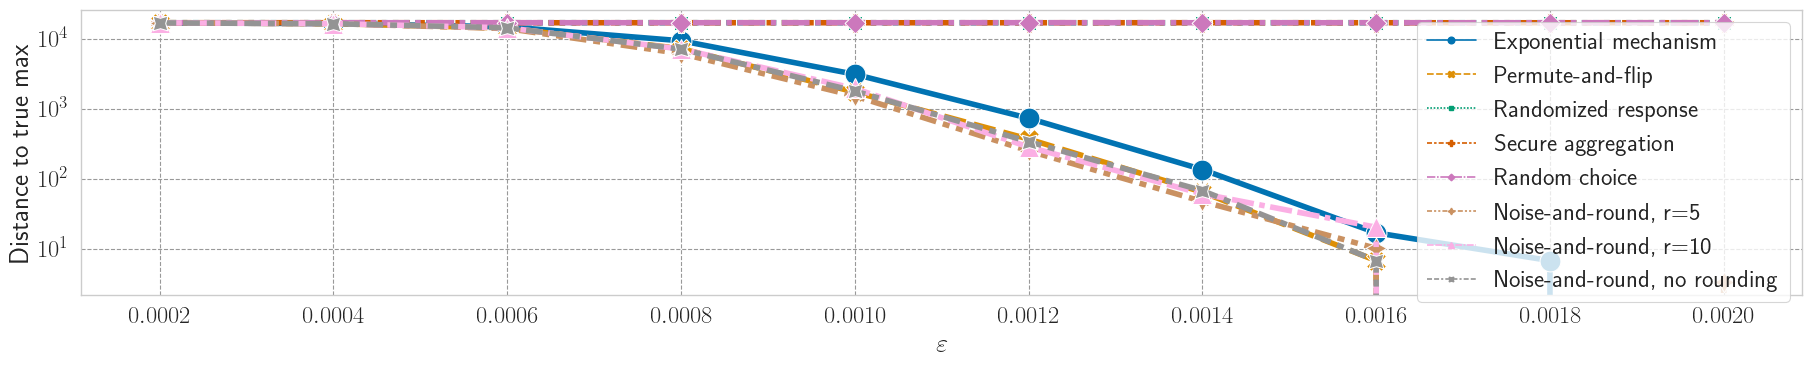

In [137]:
name = adultfrank
print('Max truncation ', calc_total_bits(datasets[name]))
bits = max(experiment_settings[name].rs)
display_rs = [bits, 10, 5]
print('Upper bound is', bits)

# Filter away r values we don't want to show in plot
hide_rs = list(set(experiment_settings[name].rs)-set(display_rs))
plot_df_searchlogs = all_errors[name]
for r in hide_rs:
    plot_df_searchlogs = plot_df_searchlogs[(plot_df_searchlogs.Algorithm != '{name}, r={r}'.format(name=our_name, r=r))]

plot_df_searchlogs = plot_df_searchlogs[plot_df_searchlogs.Algorithm != 'Geometric noisy max']
    

old_name = '{name}, r={r}'.format(name=our_name, r=bits)
new_name = '{name}, no rounding'.format(name=our_name)
plot_df_searchlogs = plot_df_searchlogs.replace(old_name, new_name)


xticks = experiment_settings[name].epsilons
xlabel = r'$\varepsilon$'
xscale = 'linear'
yscale = 'log'

    
#Print dataset name and plot
print(name)
sns.set_theme(style=grid_style, palette=palette, context='paper', font='sans-serif', font_scale=2, color_codes=True)
g = sns.lineplot(data=plot_df_searchlogs,
                 hue='Algorithm',
                 markers=True,
                 style='Algorithm',
                 x='Epsilon',
                 y='Error',
                 errorbar='sd', #Plots error bars at +-1 std
                 #err_style='bars',
                 estimator='mean',
                 ms=marker_size,
                 linewidth=line_thickness,
                 err_style=None,
                )

g.set_xscale(xscale)
g.set_yscale(yscale)
g.set_ylabel(r'Distance to true max')
g.set_xlabel(xlabel)
g.set_xticks(xticks)
g.legend().set_title(None)
g.figure.savefig(plot_name(name),bbox_inches='tight', pad_inches=0.5)

In [138]:
big_frame[name].describe()

,Exponential mechanism eps=0.0002,Exponential mechanism eps=0.0004,Exponential mechanism eps=0.0006000000000000001,Exponential mechanism eps=0.0008,Exponential mechanism eps=0.001,Exponential mechanism eps=0.0012000000000000001,Exponential mechanism eps=0.0014,Exponential mechanism eps=0.0016,Exponential mechanism eps=0.0018000000000000002,Exponential mechanism eps=0.002,Permute-and-flip eps=0.0002,Permute-and-flip eps=0.0004,Permute-and-flip eps=0.0006000000000000001,Permute-and-flip eps=0.0008,Permute-and-flip eps=0.001,Permute-and-flip eps=0.0012000000000000001,Permute-and-flip eps=0.0014,Permute-and-flip eps=0.0016,Permute-and-flip eps=0.0018000000000000002,Permute-and-flip eps=0.002,Geometric noisy max eps=0.0002,Geometric noisy max eps=0.0004,Geometric noisy max eps=0.0006000000000000001,Geometric noisy max eps=0.0008,Geometric noisy max eps=0.001,Geometric noisy max eps=0.0012000000000000001,Geometric noisy max eps=0.0014,Geometric noisy max eps=0.0016,Geometric noisy max eps=0.0018000000000000002,Geometric noisy max eps=0.002,Randomized response eps=0.0002,Randomized response eps=0.0004,Randomized response eps=0.0006000000000000001,Randomized response eps=0.0008,Randomized response eps=0.001,Randomized response eps=0.0012000000000000001,Randomized response eps=0.0014,Randomized response eps=0.0016,Randomized response eps=0.0018000000000000002,Randomized response eps=0.002,Secure aggregation eps=0.0002,Secure aggregation eps=0.0004,Secure aggregation eps=0.0006000000000000001,Secure aggregation eps=0.0008,Secure aggregation eps=0.001,Secure aggregation eps=0.0012000000000000001,Secure aggregation eps=0.0014,Secure aggregation eps=0.0016,Secure aggregation eps=0.0018000000000000002,Secure aggregation eps=0.002,Random choice eps=0.0002,Random choice eps=0.0004,Random choice eps=0.0006000000000000001,Random choice eps=0.0008,Random choice eps=0.001,Random choice eps=0.0012000000000000001,Random choice eps=0.0014,Random choice eps=0.0016,Random choice eps=0.0018000000000000002,Random choice eps=0.002,"Noise-and-round, r=0 eps=0.0002","Noise-and-round, r=0 eps=0.0004","Noise-and-round, r=0 eps=0.0006000000000000001","Noise-and-round, r=0 eps=0.0008","Noise-and-round, r=0 eps=0.001","Noise-and-round, r=0 eps=0.0012000000000000001","Noise-and-round, r=0 eps=0.0014","Noise-and-round, r=0 eps=0.0016","Noise-and-round, r=0 eps=0.0018000000000000002","Noise-and-round, r=0 eps=0.002","Noise-and-round, r=1 eps=0.0002","Noise-and-round, r=1 eps=0.0004","Noise-and-round, r=1 eps=0.0006000000000000001","Noise-and-round, r=1 eps=0.0008","Noise-and-round, r=1 eps=0.001","Noise-and-round, r=1 eps=0.0012000000000000001","Noise-and-round, r=1 eps=0.0014","Noise-and-round, r=1 eps=0.0016","Noise-and-round, r=1 eps=0.0018000000000000002","Noise-and-round, r=1 eps=0.002","Noise-and-round, r=2 eps=0.0002","Noise-and-round, r=2 eps=0.0004","Noise-and-round, r=2 eps=0.0006000000000000001","Noise-and-round, r=2 eps=0.0008","Noise-and-round, r=2 eps=0.001","Noise-and-round, r=2 eps=0.0012000000000000001","Noise-and-round, r=2 eps=0.0014","Noise-and-round, r=2 eps=0.0016","Noise-and-round, r=2 eps=0.0018000000000000002","Noise-and-round, r=2 eps=0.002","Noise-and-round, r=3 eps=0.0002","Noise-and-round, r=3 eps=0.0004","Noise-and-round, r=3 eps=0.0006000000000000001","Noise-and-round, r=3 eps=0.0008","Noise-and-round, r=3 eps=0.001","Noise-and-round, r=3 eps=0.0012000000000000001","Noise-and-round, r=3 eps=0.0014","Noise-and-round, r=3 eps=0.0016","Noise-and-round, r=3 eps=0.0018000000000000002","Noise-and-round, r=3 eps=0.002",...,"Noise-and-round, r=6 eps=0.0002","Noise-and-round, r=6 eps=0.0004","Noise-and-round, r=6 eps=0.0006000000000000001","Noise-and-round, r=6 eps=0.0008","Noise-and-round, r=6 eps=0.001","Noise-and-round, r=6 eps=0.0012000000000000001","Noise-and-round, r=6 eps=0.0014","Noise-and-round, r=6 eps=0.0016","Noise-and-round, r=6 eps=0.0018000000000000002","Noise-and-round, r=6 eps=0.002","Noise-and-round, r=7 eps=0.0002","Noise-a

## Merge into one plot for paper highlights

In [139]:
marker_size = 15
line_thickness = 4
rotate = 45

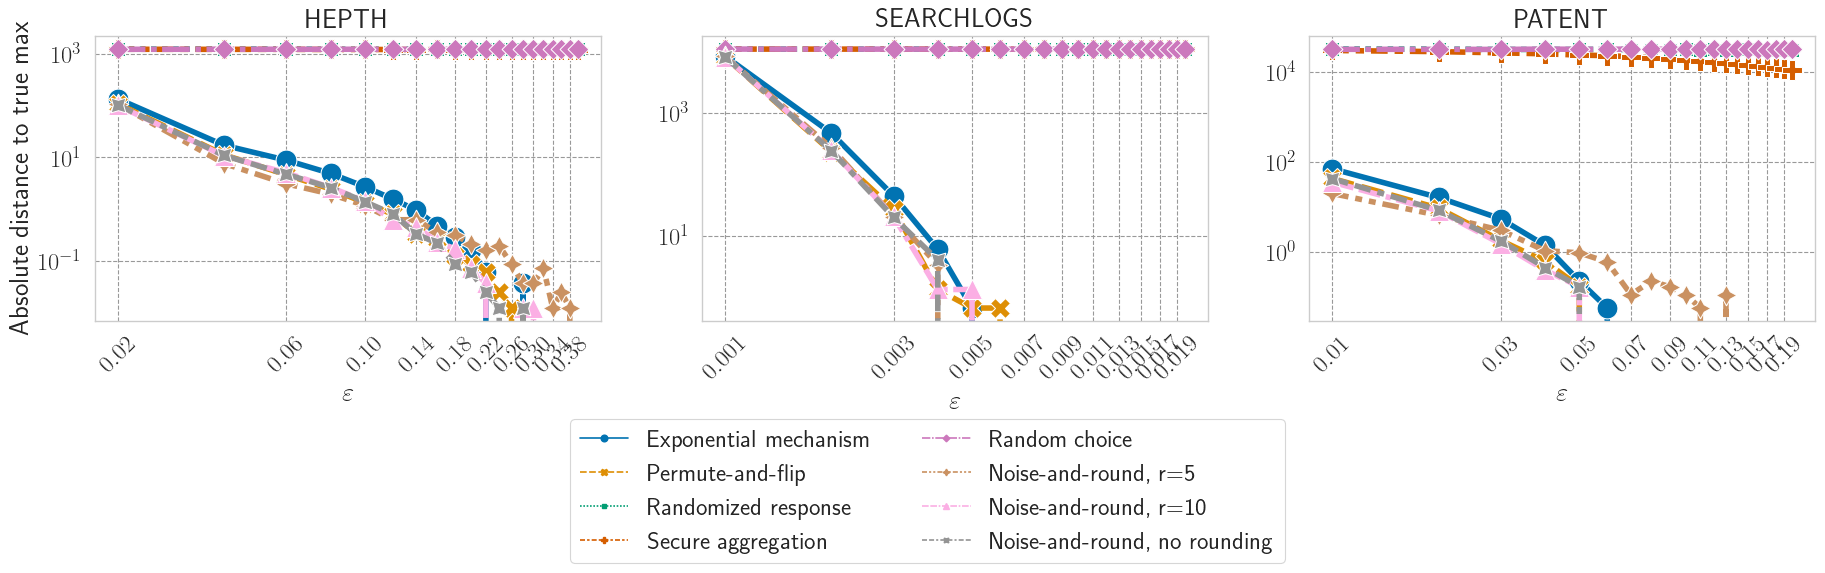

In [145]:
output_name = 'utility-plots'
fig_scale = 3.7
fig_size = (6*fig_scale, 1*fig_scale)
fig, axs = plt.subplots(ncols=3, figsize=fig_size)
xscale='log'


name = hepth
sns.set_theme(style=grid_style, palette=palette, context='paper', font='sans-serif', font_scale=2, color_codes=True)
g = sns.lineplot(data=plot_df_hepth,
                 hue='Algorithm',
                 markers=True,
                 style='Algorithm',
                 x='Epsilon',
                 y='Error',
                 #errorbar='sd', #Plots error bars at +-1 std
                 #err_style='bars',
                 estimator='mean',
                 ms=marker_size,
                 linewidth=line_thickness,
                 ax=axs[0],
                 errorbar=None,
                )

g.set_xscale(xscale)
g.set_yscale(yscale)
g.set_ylabel(r'Absolute distance to true max')
g.set_xlabel(xlabel)
xticks = experiment_settings[name].epsilons
xticks = list(set(xticks)-set(xticks[1::2])) #Filter out uneven indices
g.set_xticks(xticks)
g.set_title(name)



name = searchlogs
g = sns.lineplot(data=plot_df_searchlogs,
                 hue='Algorithm',
                 markers=True,
                 style='Algorithm',
                 x='Epsilon',
                 y='Error',
                 #errorbar='sd', #Plots error bars at +-1 std
                 #err_style='bars',
                 estimator='mean',
                 ms=marker_size,
                 linewidth=line_thickness,
                 ax=axs[1],
                 errorbar=None,
                )


g.set_xscale(xscale)
g.set_yscale(yscale)
g.set_ylabel('')
g.set_xlabel(xlabel)
xticks = experiment_settings[name].epsilons
xticks = list(set(xticks)-set(xticks[1::2]))
g.set_xticks(xticks)
g.set_title(name)


name = patent
g = sns.lineplot(data=plot_df_patent,
                 hue='Algorithm',
                 markers=True,
                 style='Algorithm',
                 x='Epsilon',
                 y='Error',
                 #errorbar='sd', #Plots error bars at +-1 std
                 #err_style='bars',
                 estimator='mean',
                 ms=marker_size,
                 linewidth=line_thickness,
                 ax=axs[2],
                 errorbar=None,
                )

g.set_xscale(xscale)
g.set_yscale(yscale)
g.set_ylabel('')
g.set_xlabel(xlabel)
xticks = experiment_settings[name].epsilons
xticks = list(set(xticks)-set(xticks[1::2]))
g.set_xticks(xticks)
g.set_title(name)


g.legend().set_title(None)

axs[0].xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter(r'${x:.2f}$'))
axs[1].xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter(r'${x:.3f}$'))
axs[2].xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter(r'${x:.2f}$'))

handles, labels = g.get_legend_handles_labels()
fig.legend(handles, labels, loc=10, ncol=2, bbox_to_anchor=(0.5, -0.35))


for ax in axs:
    ax.tick_params(axis='x', rotation=rotate)
    ax.get_legend().remove()


g.figure.savefig(plot_name(output_name),bbox_inches='tight', pad_inches=0.5)

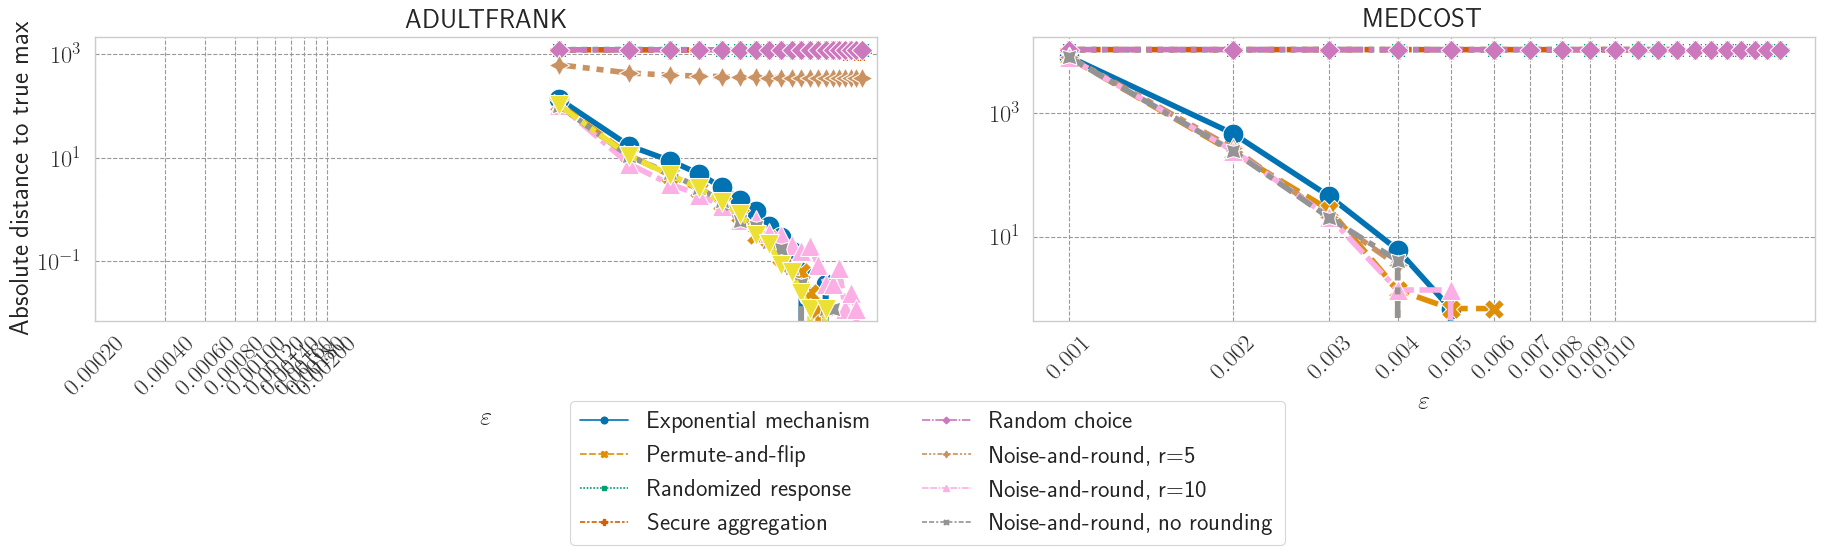

In [94]:
output_name = 'utility-plots-additional'
fig_scale = 3.7
fig_size = (6*fig_scale, 1*fig_scale)
fig, axs = plt.subplots(ncols=2, figsize=fig_size)
xscale='log'


name = adultfrank
sns.set_theme(style=grid_style, palette=palette, context='paper', font='sans-serif', font_scale=2, color_codes=True)
g = sns.lineplot(data=plot_df_hepth,
                 hue='Algorithm',
                 markers=True,
                 style='Algorithm',
                 x='Epsilon',
                 y='Error',
                 #errorbar='sd', #Plots error bars at +-1 std
                 #err_style='bars',
                 estimator='mean',
                 ms=marker_size,
                 linewidth=line_thickness,
                 ax=axs[0],
                 errorbar=None,
                )

g.set_xscale(xscale)
g.set_yscale(yscale)
g.set_ylabel(r'Absolute distance to true max')
g.set_xlabel(xlabel)
xticks = experiment_settings[name].epsilons
#xticks = list(set(xticks)-set(xticks[1::2])) #Filter out uneven indices
g.set_xticks(xticks)
g.set_title(name)



name = medcost
g = sns.lineplot(data=plot_df_searchlogs,
                 hue='Algorithm',
                 markers=True,
                 style='Algorithm',
                 x='Epsilon',
                 y='Error',
                 #errorbar='sd', #Plots error bars at +-1 std
                 #err_style='bars',
                 estimator='mean',
                 ms=marker_size,
                 linewidth=line_thickness,
                 ax=axs[1],
                 errorbar=None,
                )


g.set_xscale(xscale)
g.set_yscale(yscale)
g.set_ylabel('')
g.set_xlabel(xlabel)
xticks = experiment_settings[name].epsilons
#xticks = list(set(xticks)-set(xticks[1::2]))
g.set_xticks(xticks)
g.set_title(name)



g.legend().set_title(None)

axs[0].xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter(r'${x:.5f}$'))
axs[1].xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter(r'${x:.3f}$'))

handles, labels = g.get_legend_handles_labels()
fig.legend(handles, labels, loc=10, ncol=2, bbox_to_anchor=(0.5, -0.3))


for ax in axs:
    ax.tick_params(axis='x', rotation=rotate)
    ax.get_legend().remove()


g.figure.savefig(plot_name(output_name),bbox_inches='tight', pad_inches=0.5)

# Vary r

Max truncation  11
Upper bound is 11
HEPTH


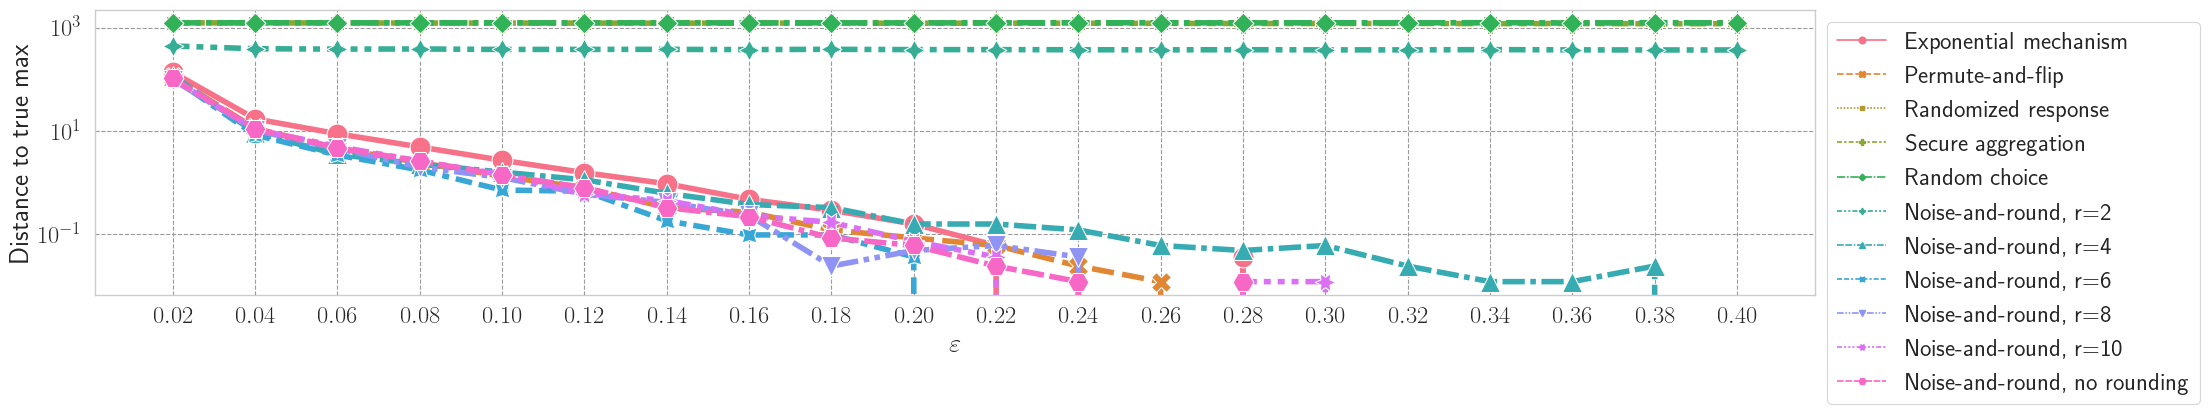

In [147]:
name = hepth
print('Max truncation ', calc_total_bits(datasets[name]))
bits = max(experiment_settings[name].rs)
display_rs = [bits, 10, 8, 6, 4, 2]#4, 3, 2, 1]
print('Upper bound is', bits)



# Filter away r values we don't want to show in plot
hide_rs = list(set(experiment_settings[name].rs)-set(display_rs))
plot_df_hepth = all_errors[hepth]
for r in hide_rs:
    plot_df_hepth = plot_df_hepth[(plot_df_hepth.Algorithm != '{name}, r={r}'.format(name=our_name, r=r))]

plot_df_hepth = plot_df_hepth[plot_df_hepth.Algorithm != 'Geometric noisy max']
    
old_name = '{name}, r={r}'.format(name=our_name, r=bits)
new_name = '{name}, no rounding'.format(name=our_name)
plot_df_hepth = plot_df_hepth.replace(old_name, new_name)



xticks = experiment_settings[name].epsilons
xlabel = r'$\varepsilon$'
xscale = 'linear'
yscale = 'log'


plt.rcParams['figure.figsize'] = fig_size

    
#Print dataset name and plot
print(name)
sns.set_theme(style=grid_style, palette=palette, context='paper', font='sans-serif', font_scale=2, color_codes=True)
g = sns.lineplot(data=plot_df_hepth,
                 hue='Algorithm',
                 markers=True,
                 style='Algorithm',
                 x='Epsilon',
                 y='Error',
                 errorbar='sd', #Plots error bars at +-1 std
                 #err_style='bars',
                 estimator='mean',
                 ms=marker_size,
                 linewidth=line_thickness,
                 err_style=None,
                )

g.set_xscale(xscale)
g.set_yscale(yscale)
g.set_ylabel(r'Distance to true max')
g.set_xlabel(xlabel)
g.set_xticks(xticks)
g.legend().set_title(None)
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
g.figure.savefig(plot_name(name),bbox_inches='tight', pad_inches=0.5)

Max truncation  16
Upper bound is 16
PATENT


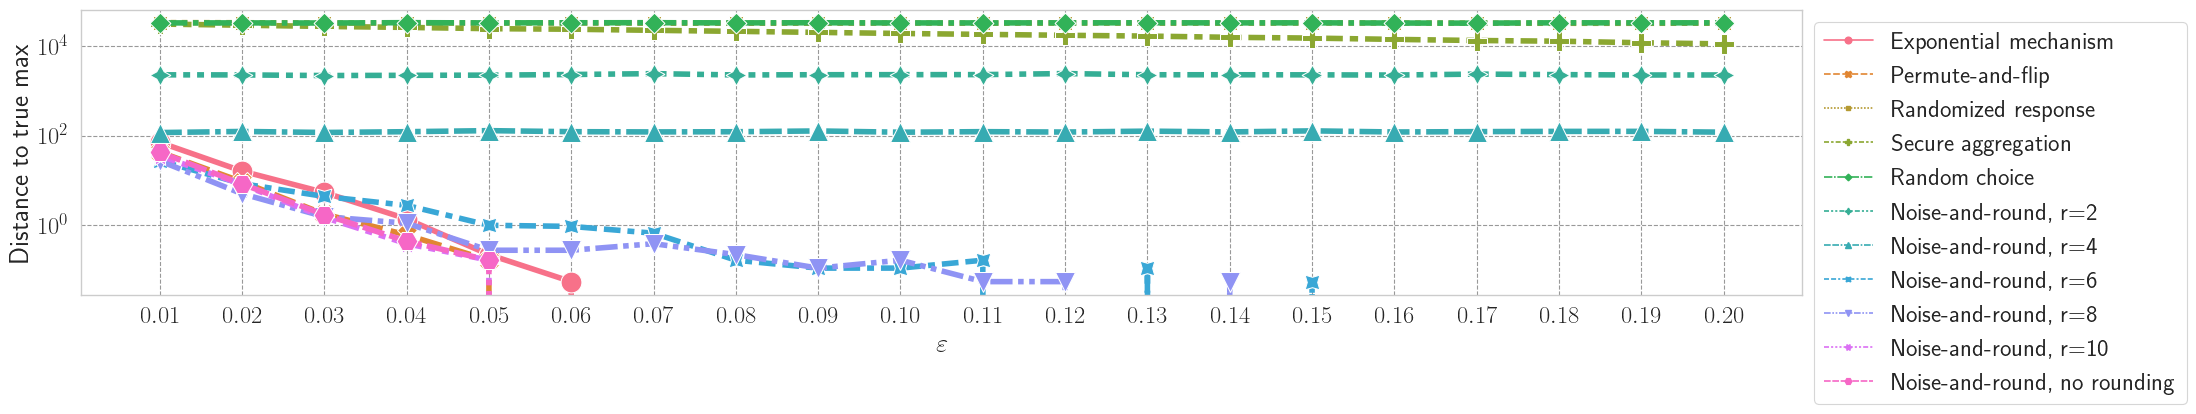

In [148]:
name = patent
print('Max truncation ', calc_total_bits(datasets[name]))
bits = max(experiment_settings[name].rs)
display_rs = [bits, 10, 8, 6, 4, 2]# 4, 3, 2, 1]
print('Upper bound is', bits)

# Filter away r values we don't want to show in plot
hide_rs = list(set(experiment_settings[name].rs)-set(display_rs))
plot_df_patent = all_errors[name]
for r in hide_rs:
    plot_df_patent = plot_df_patent[(plot_df_patent.Algorithm != '{name}, r={r}'.format(name=our_name, r=r))]

plot_df_patent = plot_df_patent[plot_df_patent.Algorithm != 'Geometric noisy max']
    

old_name = '{name}, r={r}'.format(name=our_name, r=bits)
new_name = '{name}, no rounding'.format(name=our_name)
plot_df_patent = plot_df_patent.replace(old_name, new_name)


xticks = experiment_settings[name].epsilons
xlabel = r'$\varepsilon$'
xscale = 'linear'
yscale = 'log'

    
#Print dataset name and plot
print(name)
sns.set_theme(style=grid_style, palette=palette, context='paper', font='sans-serif', font_scale=2, color_codes=True)
g = sns.lineplot(data=plot_df_patent,
                 hue='Algorithm',
                 markers=True,
                 style='Algorithm',
                 x='Epsilon',
                 y='Error',
                 errorbar='sd', #Plots error bars at +-1 std
                 #err_style='bars',
                 estimator='mean',
                 ms=marker_size,
                 linewidth=line_thickness,
                 err_style=None,
                )

g.set_xscale(xscale)
g.set_yscale(yscale)
g.set_ylabel(r'Distance to true max')
g.set_xlabel(xlabel)
g.set_xticks(xticks)
g.legend().set_title(None)

sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
g.figure.savefig(plot_name(name),bbox_inches='tight', pad_inches=0.5)

Max truncation  14
Upper bound is 14
SEARCHLOGS


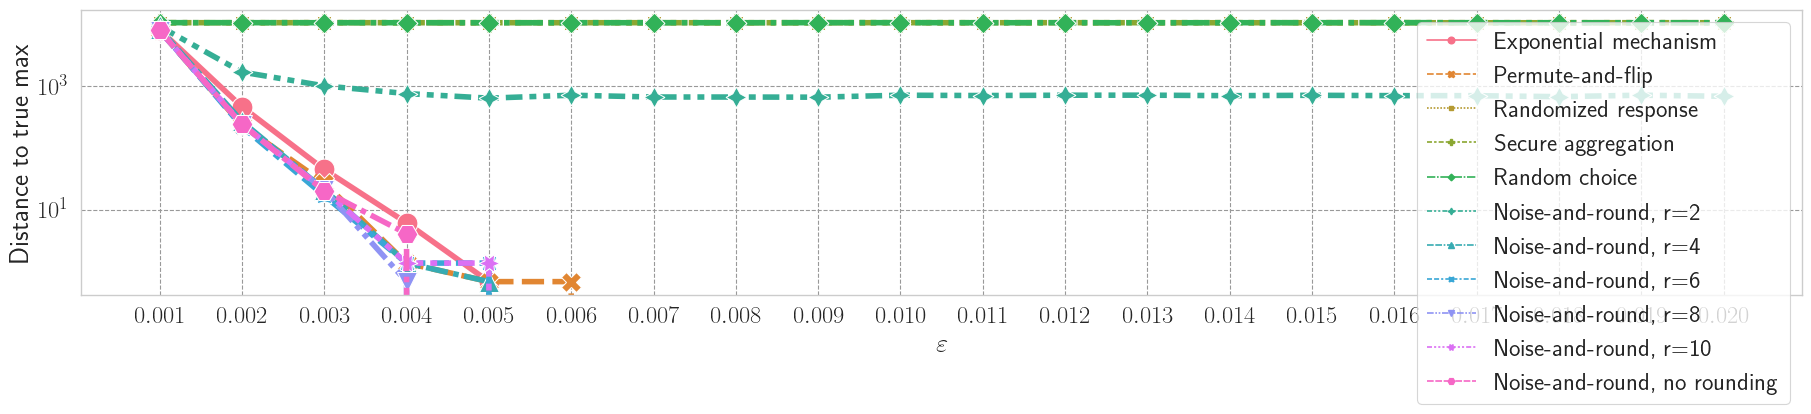

In [149]:
name = searchlogs
print('Max truncation ', calc_total_bits(datasets[name]))
bits = max(experiment_settings[name].rs)
display_rs = [bits, 10, 8, 6, 4, 2] # 4, 3, 2, 1]
print('Upper bound is', bits)

# Filter away r values we don't want to show in plot
hide_rs = list(set(experiment_settings[name].rs)-set(display_rs))
plot_df_searchlogs = all_errors[name]
for r in hide_rs:
    plot_df_searchlogs = plot_df_searchlogs[(plot_df_searchlogs.Algorithm != '{name}, r={r}'.format(name=our_name, r=r))]

plot_df_searchlogs = plot_df_searchlogs[plot_df_searchlogs.Algorithm != 'Geometric noisy max']
    

old_name = '{name}, r={r}'.format(name=our_name, r=bits)
new_name = '{name}, no rounding'.format(name=our_name)
plot_df_searchlogs = plot_df_searchlogs.replace(old_name, new_name)


xticks = experiment_settings[name].epsilons
xlabel = r'$\varepsilon$'
xscale = 'linear'
yscale = 'log'

    
#Print dataset name and plot
print(name)
sns.set_theme(style=grid_style, palette=palette, context='paper', font='sans-serif', font_scale=2, color_codes=True)
g = sns.lineplot(data=plot_df_searchlogs,
                 hue='Algorithm',
                 markers=True,
                 style='Algorithm',
                 x='Epsilon',
                 y='Error',
                 errorbar='sd', #Plots error bars at +-1 std
                 #err_style='bars',
                 estimator='mean',
                 ms=marker_size,
                 linewidth=line_thickness,
                 err_style=None,
                )

g.set_xscale(xscale)
g.set_yscale(yscale)
g.set_ylabel(r'Distance to true max')
g.set_xlabel(xlabel)
g.set_xticks(xticks)
g.legend().set_title(None)
g.figure.savefig(plot_name(name),bbox_inches='tight', pad_inches=0.5)

In [162]:
plot_df_hepth_filtered = plot_df_hepth[plot_df_hepth.Algorithm.str.contains('round')]
plot_df_searchlogs_filtered = plot_df_searchlogs[plot_df_searchlogs.Algorithm.str.contains('round')]
plot_df_patent_filtered = plot_df_patent[plot_df_patent.Algorithm.str.contains('round')]


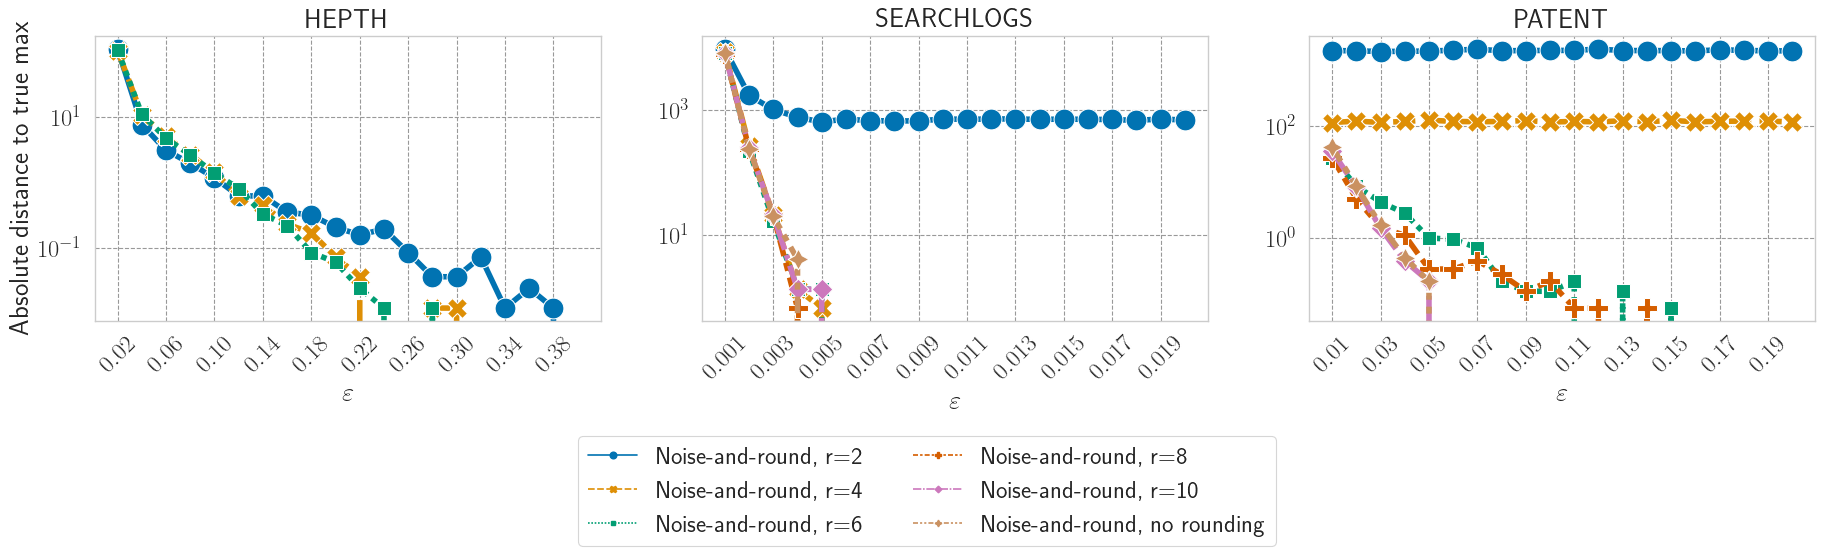

In [168]:
output_name = 'utility-plots-extended-r'
fig_scale = 3.7
fig_size = (6*fig_scale, 1*fig_scale)
fig, axs = plt.subplots(ncols=3, figsize=fig_size)
xscale='linear'#'log'


name = hepth
sns.set_theme(style=grid_style, palette=palette, context='paper', font='sans-serif', font_scale=2, color_codes=True)
g = sns.lineplot(data=plot_df_hepth_filtered,
                 hue='Algorithm',
                 markers=True,
                 style='Algorithm',
                 x='Epsilon',
                 y='Error',
                 #errorbar='sd', #Plots error bars at +-1 std
                 #err_style='bars',
                 estimator='mean',
                 ms=marker_size,
                 linewidth=line_thickness,
                 ax=axs[0],
                 errorbar=None,
                )

g.set_xscale(xscale)
g.set_yscale(yscale)
g.set_ylabel(r'Absolute distance to true max')
g.set_xlabel(xlabel)
xticks = experiment_settings[name].epsilons
xticks = list(set(xticks)-set(xticks[1::2])) #Filter out uneven indices
g.set_xticks(xticks)
g.set_title(name)



name = searchlogs
g = sns.lineplot(data=plot_df_searchlogs_filtered,
                 hue='Algorithm',
                 markers=True,
                 style='Algorithm',
                 x='Epsilon',
                 y='Error',
                 #errorbar='sd', #Plots error bars at +-1 std
                 #err_style='bars',
                 estimator='mean',
                 ms=marker_size,
                 linewidth=line_thickness,
                 ax=axs[1],
                 errorbar=None,
                )


g.set_xscale(xscale)
g.set_yscale(yscale)
g.set_ylabel('')
g.set_xlabel(xlabel)
xticks = experiment_settings[name].epsilons
xticks = list(set(xticks)-set(xticks[1::2]))
g.set_xticks(xticks)
g.set_title(name)


name = patent
g = sns.lineplot(data=plot_df_patent_filtered,
                 hue='Algorithm',
                 markers=True,
                 style='Algorithm',
                 x='Epsilon',
                 y='Error',
                 #errorbar='sd', #Plots error bars at +-1 std
                 #err_style='bars',
                 estimator='mean',
                 ms=marker_size,
                 linewidth=line_thickness,
                 ax=axs[2],
                 errorbar=None,
                )

g.set_xscale(xscale)
g.set_yscale(yscale)
g.set_ylabel('')
g.set_xlabel(xlabel)
xticks = experiment_settings[name].epsilons
xticks = list(set(xticks)-set(xticks[1::2]))
g.set_xticks(xticks)
g.set_title(name)


g.legend().set_title(None)

axs[0].xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter(r'${x:.2f}$'))
axs[1].xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter(r'${x:.3f}$'))
axs[2].xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter(r'${x:.2f}$'))

handles, labels = g.get_legend_handles_labels()
fig.legend(handles, labels, loc=10, ncol=2, bbox_to_anchor=(0.5, -0.35))


for ax in axs:
    ax.tick_params(axis='x', rotation=rotate)
    ax.get_legend().remove()


g.figure.savefig(plot_name(output_name),bbox_inches='tight', pad_inches=0.5)